In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Java and Spark in Google Colab Environment

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

### Configuring Environment Variable for the Java and Spark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

### Importing findspark and SparkSession (which will be used during Model Processing)

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *

### Importing Datasets

In [ ]:
data = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Credit_Card_Approval/application_record.csv",inferSchema=True, header =True,encoding = 'utf-8') 
record = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Credit_Card_Approval/credit_record.csv",inferSchema=True, header =True, encoding = 'utf-8')  

# Data Exploration

### Let us print look into the dataset to see the data types of each column

In [ ]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)



In [ ]:
record.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)



In [ ]:
df = data.toPandas()
df_r = record.toPandas()

In [ ]:
print("Shape of Application dataset is : ", df.shape)
df.head()

Shape of Application dataset is :  (438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
print("Shape of Credit dataset is : ", df_r.shape)
df_r.head()

Shape of Credit dataset is :  (1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


### How can we classify that the credit card user is not approiate enough to give further credits ?
#### The Status shows how late the customer paid the credit card Bill.
* 0: 1-29 days
* 1: 30-59 days
* 2: 60-89 days 
* 3: 90-119 days 
* 4: 120-149 days 
* 5: Overdue or bad debts write-offs for more than 150 days 
* C: paid off that month 
* X: No loan for the month




In [ ]:
df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

Lets find out when the customer opened his account (Ex. -49 means opened account 49 months ago)

In [ ]:
# find all users' account open month. 0 = current month, -1 = previous month and so on..
begin_month=pd.DataFrame(df_r.groupby(["ID"]).MONTHS_BALANCE.agg("min"))
begin_month

,MONTHS_BALANCE
ID,
5001711,-3
5001712,-18
5001713,-21
5001714,-14
5001715,-59
...,...
5150482,-28
5150483,-17
5150484,-12


Merged the record in the attribute Table (Left Join using ID as a common column)

In [ ]:
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'starting_month'}) 
new_data=pd.merge(df,begin_month,how="left",on="ID") #merge to record data
new_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,starting_month
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0


We are assuming that if the customer paid very late payment (More than 60 days) We consider them as risky customer ( Might not pay the bill in future)

So we are labeling all the customer with status 2,3,4,5 as Yes (Risk) others are Safe to give credit( Now by default it is None)

New Column added as target_value

In [ ]:
df_r['dep_value'] = None
df_r['dep_value'][df_r['STATUS'] =='2']='Yes' 
df_r['dep_value'][df_r['STATUS'] =='3']='Yes' 
df_r['dep_value'][df_r['STATUS'] =='4']='Yes' 
df_r['dep_value'][df_r['STATUS'] =='5']='Yes' 


df_r.rename(columns= { "dep_value" : "target_value"}, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

Set None values as No or Yes depending other attirbute and merge the column with attribute table and Convert Yes and No into 1 and O.

In [ ]:
count_df = df_r.groupby("ID").count() #None - 0(No) otherwise NonZero(Yes)
count_df["target_value"][count_df["target_value"] > 0] = "Yes"
count_df["target_value"][count_df["target_value"] == 0] = "No"
count_df = count_df[["target_value"]]
new_data = pd.merge(new_data, count_df, how="inner", on="ID")
new_data.loc[new_data["target_value"] == "Yes","target_value"] = 1
new_data.loc[new_data["target_value"] == "No","target_value"] = 0
new_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,starting_month,target_value
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


How many Yes and No are in the Dataset (Seems like a skewed Dataset)

In [ ]:
print(count_df['target_value'].value_counts())
count_df['target_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: target_value, dtype: int64


No     0.985495
Yes    0.014505
Name: target_value, dtype: float64

Renaming Columns for Clean Code

In [ ]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'income',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'fam_status',
                        'NAME_HOUSING_TYPE':'housingtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'incometp','FLAG_WORK_PHONE':'workphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'familysize',
                        'OCCUPATION_TYPE':'occytp'
                        },inplace=True)

Drop NULL Values

In [ ]:
new_data.dropna()
new_data = new_data.mask(new_data == None).dropna()
new_data.isnull().sum()

ID                0
Gender            0
Car               0
Reality           0
ChldNo            0
income            0
incometp          0
edutp             0
fam_status        0
housingtp         0
DAYS_BIRTH        0
DAYS_EMPLOYED     0
FLAG_MOBIL        0
workphone         0
phone             0
email             0
occytp            0
familysize        0
starting_month    0
target_value      0
dtype: int64

Create new table which will contain information value of each attribute so, we can idendify which attribute is more important for classification.

In [ ]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','starting_month','target_value','ID']
for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

In [ ]:
ivtable

,variable,IV
1,Gender,None
2,Car,None
3,Reality,None
4,ChldNo,None
5,income,None
6,incometp,None
7,edutp,None
8,fam_status,None
9,housingtp,None
10,DAYS_BIRTH,None


In [ ]:
sns.set_style("whitegrid")

Function to calculate the Information Value of Attribute(Column) depending on classification

In [ ]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

Function for coverting categorical varible to numerical values (Using multiple columns)

In [ ]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [ ]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

Ploting Confusion Matrix for better visulization

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Binary Features

#### Finding the IV score of all the unique values of Binary Features

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'ChldNo', 'income', 'incometp',
       'edutp', 'fam_status', 'housingtp', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'workphone', 'phone', 'email', 'occytp', 'familysize',
       'starting_month', 'target_value'],
      dtype='object')

Calculate Infomation Values for all the features

In [ ]:
binary_features = ['Gender', 'Car', 'Reality', 'workphone', 'phone', 'email']
for i in binary_features:
    new_data[i] = pd.get_dummies(new_data[i])
    iv, data = calc_iv(new_data,i,'target_value')
    ivtable.loc[ivtable['variable']==i,'IV']=iv
ivtable

This variable's IV is: 0.02520350452745081
1    15630
0     9504
Name: Gender, dtype: int64
This variable's IV is: 4.54248124999671e-06
1    14618
0    10516
Name: Car, dtype: int64
This variable's IV is: 0.02744070350168343
0    16461
1     8673
Name: Reality, dtype: int64
This variable's IV is: 0.002042429795148461
1    18252
0     6882
Name: workphone, dtype: int64
This variable's IV is: 0.0005480495762639297
1    17775
0     7359
Name: phone, dtype: int64
This variable's IV is: 1.7343581493999816e-05
1    22604
0     2530
Name: email, dtype: int64


,variable,IV
1,Gender,0.0252035
2,Car,4.54248e-06
3,Reality,0.0274407
4,ChldNo,None
5,income,None
6,incometp,None
7,edutp,None
8,fam_status,None
9,housingtp,None
10,DAYS_BIRTH,None


# Continous Features

Just make 3 groups for # of childs (0 , 1 ,2 or more than 2) 

In [ ]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2 or More'
print(new_data['ChldNo'].value_counts(sort=False))

0            15908
1             6118
2 or More     3108
Name: ChldNo, dtype: int64


In [ ]:
iv, data=calc_iv(new_data,'ChldNo','target_value')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()
new_data = convert_dummy(new_data, 'ChldNo')
new_data.head()

This variable's IV is: 0.0011214542503301935
0            15908
1             6118
2 or More     3108
Name: ChldNo, dtype: int64


,ID,Gender,Car,Reality,income,incometp,edutp,fam_status,housingtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,workphone,phone,email,occytp,familysize,starting_month,target_value,ChldNo_1,ChldNo_2 or More
2,5008806,0,0,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,1,1,1,Security staff,2.0,-29.0,0,0,0
3,5008808,1,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,1,0,0,Sales staff,1.0,-4.0,0,0,0
4,5008809,1,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,1,0,0,Sales staff,1.0,-26.0,0,0,0
5,5008810,1,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,1,0,0,Sales staff,1.0,-26.0,0,0,0
6,5008811,1,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,1,0,0,Sales staff,1.0,-38.0,0,0,0


Converting Income to Categories (Requires Binning)

In [ ]:
new_data

,ID,Gender,Car,Reality,income,incometp,edutp,fam_status,housingtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,workphone,phone,email,occytp,familysize,starting_month,target_value,ChldNo_1,ChldNo_2 or More
2,5008806,0,0,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,1,1,1,Security staff,2.0,-29.0,0,0,0
3,5008808,1,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,1,0,0,Sales staff,1.0,-4.0,0,0,0
4,5008809,1,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,1,0,0,Sales staff,1.0,-26.0,0,0,0
5,5008810,1,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,1,0,0,Sales staff,1.0,-26.0,0,0,0
6,5008811,1,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,1,0,0,Sales staff,1.0,-38.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,0,0,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,1,1,1,Managers,2.0,-11.0,1,0,0
36453,5149834,1,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,1,0,0,Medicine staff,2.0,-23.0,1,0,0
36454,5149838,1,1,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,1,0,0,Medicine staff,2.0,-32.0,1,0,0
36455,5150049,1,1,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,1,1,1,Sales staff,2.0,-9.0,1,0,0


(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income, dtype: int64


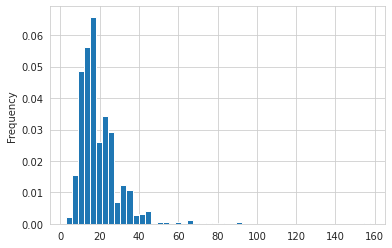

In [ ]:
new_data['income']=new_data['income'].astype(object)
new_data['income'] = new_data['income']/10000 
print(new_data['income'].value_counts(bins=10,sort=False))
new_data['income'].plot(kind='hist',bins=50,density=True)

Categorize the income into 3 groups low , medium , high

In [ ]:
new_data = get_category(new_data,'income', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_income','target_value')
ivtable.loc[ivtable['variable']=='income','IV']=iv
data.head()
new_data = convert_dummy(new_data,'gp_income')

This variable's IV is: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_income, dtype: int64


Convering Days into Years and Binning on age (Analysis Purposes)

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


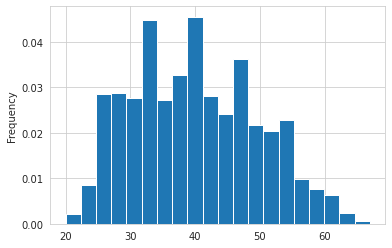

In [ ]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

After analysing the Graph we can conclude that size of 5 for category would be good balance for the model (Generalization with minimizing infomation loss)

Calculating IV Values and Using Premade function to label the Age Column

In [ ]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target_value')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()
new_data = convert_dummy(new_data,'gp_Age')

This variable's IV is: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


Same for the Work Experience (Fill nan values with mean values : Handling Missing/Errogenous Values)

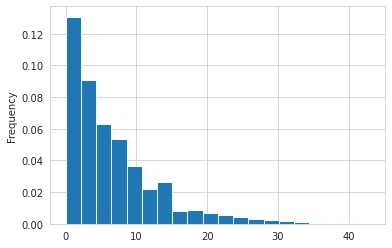

In [ ]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365	
new_data[new_data['worktm']<0] = np.nan
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) 
new_data['worktm'].plot(kind='hist',bins=20,density=True)

Grouping into 5 Categories (Work Time)

In [ ]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target_value')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()
new_data = convert_dummy(new_data,'gp_worktm')


This variable's IV is: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


For Family Size : Convert into 3 group ( 1 , 2 , 3 or more) and calculate Information Value

In [ ]:
new_data['familysize']=new_data['familysize'].astype(int)
new_data['famsizegp']=new_data['familysize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target_value')
ivtable.loc[ivtable['variable']=='familysize','IV']=iv
data.head()
new_data = convert_dummy(new_data,'famsizegp')

This variable's IV is: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


Convert Pensioner and Student to State Servant

Calculate IV values for the Income Type

In [ ]:
print(new_data['incometp'].value_counts(normalize=True,sort=False))
new_data.loc[(new_data['incometp']=='Pensioner') | (new_data['incometp']=='Student'),'incometp']='State servant'
iv, data=calc_iv(new_data,'incometp','target_value')
ivtable.loc[ivtable['variable']=='incometp','IV']=iv
data.head()
new_data = convert_dummy(new_data,'incometp')

Working                 0.621549
State servant           0.096960
Commercial associate    0.280576
Pensioner               0.000517
Student                 0.000398
Name: incometp, dtype: float64
This variable's IV is: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: incometp, dtype: int64


Manualling Categorizing the Occupation in 3 categories (Labor work , office work , High Tech work)

In [ ]:
new_data.loc[new_data["occytp"].isin(["Cleaning staff",'Cooking staff',"Drivers", "Laborers", 'Low-skill Laborers', 'Security staff','Waiters/barmen staff']),"occytp"] = 'Laborwk'
new_data.loc[new_data["occytp"].isin(["Accountants",'Core staff',"HR staff", "Medicine staff", 'Private service staff', 'Realty agents','Sales staff','Secretaries']),"occytp"] = 'officewk'
new_data.loc[new_data['occytp'].isin(['Managers','High skill tech staff','IT staff']),'occytp']='hightecwk'

In [ ]:
print(new_data['occytp'].value_counts())
iv, data=calc_iv(new_data,'occytp','target_value')
ivtable.loc[ivtable['variable']=='occytp','IV']=iv
data.head()    
new_data = convert_dummy(new_data,'occytp')     

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occytp, dtype: int64
This variable's IV is: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occytp, dtype: int64


Housing Type

In [ ]:
iv, data=calc_iv(new_data,'housingtp','target_value')
ivtable.loc[ivtable['variable']=='housingtp','IV']=iv
data.head()
new_data = convert_dummy(new_data,'housingtp')     

This variable's IV is: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: housingtp, dtype: int64


Education Type

In [ ]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target_value')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()
new_data = convert_dummy(new_data,'edutp') 


This variable's IV is: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


Family Status

In [ ]:
iv, data=calc_iv(new_data,'fam_status','target_value')
ivtable.loc[ivtable['variable']=='fam_status','IV']=iv
data.head()
new_data = convert_dummy(new_data,'fam_status')


This variable's IV is: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: fam_status, dtype: int64


# Now analysing all the Attributes through IV table

As per table most important attributes are age group , family status , work experience , .....

whereas Least Important Attributes are Car , Email availabily ,income type(surprisingly) , phone availibily

In [ ]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.0659351
8,fam_status,0.0431371
11,worktmgp,0.0402215
3,Reality,0.0274407
1,Gender,0.0252035
7,edutp,0.0103618
9,housingtp,0.0073275
17,familysize,0.00615614
16,occytp,0.00482047
5,income,0.002422


# Machine Learning Algorithms

First Only Take Attributes which is required for the model to train

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'income', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'workphone', 'phone', 'email',
       'familysize', 'starting_month', 'target_value', 'ChldNo_1',
       'ChldNo_2 or More', 'gp_income_high', 'gp_income_medium', 'Age',
       'gp_Age_high', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest',
       'worktm', 'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'incometp_Commercial associate', 'incometp_State servant',
       'occytp_hightecwk', 'occytp_officewk', 'housingtp_Co-op apartment',
       'housingtp_Municipal apartment', 'housingtp_Office apartment',
       'housingtp_Rented apartment', 'housingtp_With parents',
       'edutp_Higher education', 'edutp_Incomplete higher',
       'edutp_Lower secondary', 'fam_status_Civil marriage',
       'fam_status_Separated', 'fam_status_Single / not married',
       'fam_status_Widow'],
      dtype='object')

dataset contains all the independent variable with dependent variable as well (target_value) 

In [ ]:
dataset = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2 or More','workphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occytp_hightecwk', 
              'occytp_officewk','famsizegp_1', 'famsizegp_3more',
       'housingtp_Co-op apartment', 'housingtp_Municipal apartment',
       'housingtp_Office apartment', 'housingtp_Rented apartment',
       'housingtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','fam_status_Civil marriage',
       'fam_status_Separated','fam_status_Single / not married','fam_status_Widow','target_value']]

## Spliting Dataset into Training : 79% , Testing : 21%

Spark MLlib only support spark dataframe for the models so we have convert our pandas dataframe into spark dataframe

In [ ]:
df = spark.createDataFrame(dataset)

Set the attributes list to the assembler (which is responsible for assembling all the features into one columns )

In [ ]:
feature_columns = list(dataset.columns[:-1])# here we omit the final column


from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")

Assembler tranforming dataframe to usable dataframe for models (merging features columns into one column with comma separation)

In [ ]:
AllinOne = assembler.transform(df)
AllinOne.show()

+------+-------+--------+----------------+---------+-----------+--------------+----------+-------------+--------------+-----------------+-------------+----------------+----------------+---------------+-----------+---------------+-------------------------+-----------------------------+--------------------------+--------------------------+----------------------+----------------------+-----------------------+---------------------+-------------------------+--------------------+-------------------------------+----------------+------------+--------------------+
|Gender|Reality|ChldNo_1|ChldNo_2 or More|workphone|gp_Age_high|gp_Age_highest|gp_Age_low|gp_Age_lowest|gp_worktm_high|gp_worktm_highest|gp_worktm_low|gp_worktm_medium|occytp_hightecwk|occytp_officewk|famsizegp_1|famsizegp_3more|housingtp_Co-op apartment|housingtp_Municipal apartment|housingtp_Office apartment|housingtp_Rented apartment|housingtp_With parents|edutp_Higher education|edutp_Incomplete higher|edutp_Lower secondary|fam_sta

In [ ]:
train, test = AllinOne.randomSplit([0.79, 0.21], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 19867
Test Dataset Count: 5267


## Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'target_value', maxIter=10)
lrModel = lr.fit(train)

Accuracy : 61.90 %

In [ ]:
evaluation_summary = lrModel.evaluate(test)

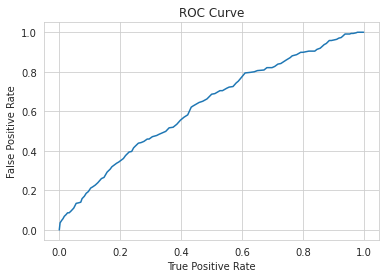

Training set areaUnderROC: 0.6238041056238366


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Decision Tree Classifier

Fitting Train and Test Dataset

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'target_value', maxDepth = 4)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
train_prediction = dtModel.transform(train)


Evaulating both prediction
1. Testing dataset : 98.45 %
2. Training dataset : 98.30 %

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="target_value", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
accuracy

0.9836719194987659

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="target_value", predictionCol="prediction", metricName="accuracy")
train_accuracy = evaluator.evaluate(train_prediction)
train_accuracy

0.9834398751698797

In [ ]:
data = predictions.select('prediction', 'probability', 'target_value').toPandas()
data

,prediction,probability,target_value
0,0.0,"[0.9867201426024955, 0.013279857397504456]",0
1,0.0,"[0.9867201426024955, 0.013279857397504456]",0
2,0.0,"[0.9867201426024955, 0.013279857397504456]",0
3,0.0,"[0.9867201426024955, 0.013279857397504456]",0
4,0.0,"[0.9867201426024955, 0.013279857397504456]",0
...,...,...,...
5262,0.0,"[0.9809820193637621, 0.019017980636237896]",0
5263,0.0,"[0.9809820193637621, 0.019017980636237896]",0
5264,0.0,"[0.9809820193637621, 0.019017980636237896]",0
5265,0.0,"[0.9770590447536668, 0.022940955246333206]",0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, title):
  # Clear Plot
  plt.gcf().clear()

  # Configure figure
  fig = plt.figure(1)
  
  # Configure plot
  classes = ['No Fraud', 'Fraud']
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  # Normalize and establish threshold
  normalize=False
  fmt = 'd'
  thresh = cm.max() / 2.

  # Iterate through the confusion matrix cells
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  # Final plot configurations
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label') 
  
  # Display images
  image = fig
  
  # Show plot
  #fig = plt.show()
  
  # Save plot
  fig.savefig("confusion-matrix.png")

  # Display Plot
  display(image)
  
  # Close Plot
  plt.close(fig)


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data["prediction"], data["target_value"])


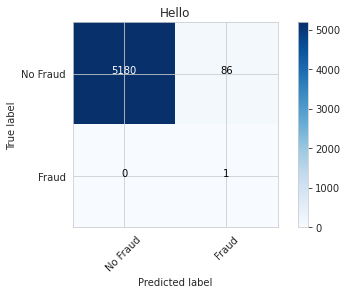

In [ ]:
plot_confusion_matrix(cm, "Hello")